In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average
import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
l = 0.5
step = 40000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode, pure=1)

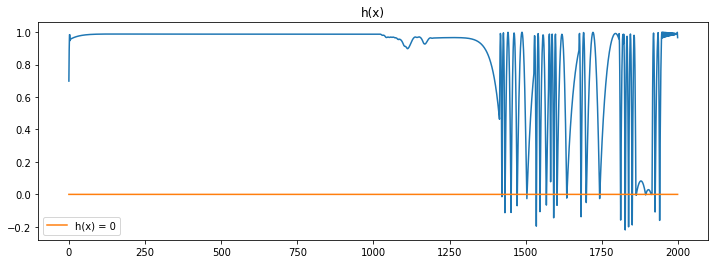

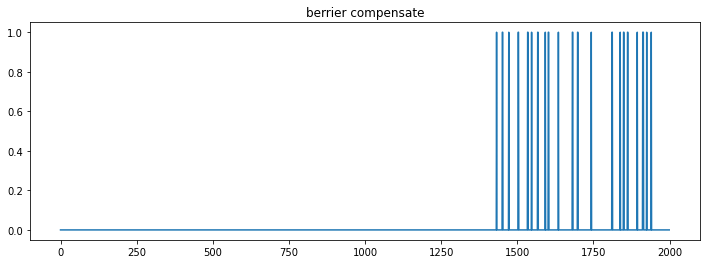

In [21]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

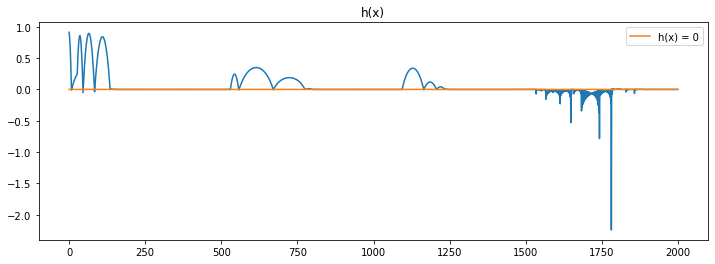

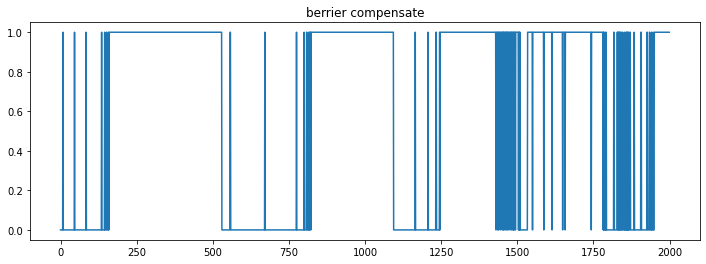

In [26]:
# log per episode
interval = 10
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

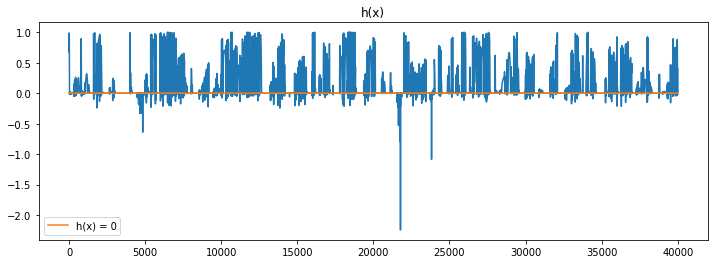

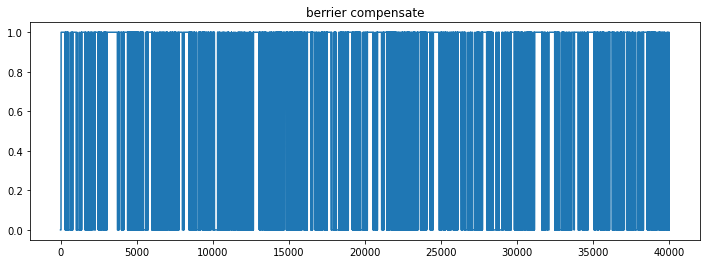

In [27]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [8]:
a.load_weights('../learned_models_safe/3000000_e2000_l05_pure.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=1, time_mode=time_mode, pure=1)

Testing for 1 episodes ...
step =  1 , output of actor network =  -inf
step =  2 , output of actor network =  -inf
step =  3 , output of actor network =  -inf
step =  4 , output of actor network =  -inf
step =  5 , output of actor network =  -inf
step =  6 , output of actor network =  -inf
step =  7 , output of actor network =  -inf
step =  8 , output of actor network =  -inf
step =  9 , output of actor network =  -inf
step =  10 , output of actor network =  -inf
step =  11 , output of actor network =  -inf
step =  12 , output of actor network =  -inf
step =  13 , output of actor network =  -inf
step =  14 , output of actor network =  -inf
step =  15 , output of actor network =  -inf
step =  16 , output of actor network =  -inf
step =  17 , output of actor network =  -inf
step =  18 , output of actor network =  -inf
step =  19 , output of actor network =  -inf
step =  20 , output of actor network =  -inf
step =  21 , output of actor network =  -inf
step =  22 , output of actor network 

step =  220 , output of actor network =  -inf
step =  221 , output of actor network =  -inf
step =  222 , output of actor network =  -inf
step =  223 , output of actor network =  -inf
step =  224 , output of actor network =  -inf
step =  225 , output of actor network =  -inf
step =  226 , output of actor network =  -inf
step =  227 , output of actor network =  -inf
step =  228 , output of actor network =  -inf
step =  229 , output of actor network =  -inf
step =  230 , output of actor network =  -inf
step =  231 , output of actor network =  -inf
step =  232 , output of actor network =  -inf
step =  233 , output of actor network =  -inf
step =  234 , output of actor network =  -inf
step =  235 , output of actor network =  -inf
step =  236 , output of actor network =  -inf
step =  237 , output of actor network =  -inf
step =  238 , output of actor network =  -inf
step =  239 , output of actor network =  -inf
step =  240 , output of actor network =  -inf
step =  241 , output of actor netw

step =  427 , output of actor network =  -inf
step =  428 , output of actor network =  -inf
step =  429 , output of actor network =  -inf
step =  430 , output of actor network =  -inf
step =  431 , output of actor network =  -inf
step =  432 , output of actor network =  -inf
step =  433 , output of actor network =  -inf
step =  434 , output of actor network =  -inf
step =  435 , output of actor network =  -inf
step =  436 , output of actor network =  -inf
step =  437 , output of actor network =  -inf
step =  438 , output of actor network =  -inf
step =  439 , output of actor network =  -inf
step =  440 , output of actor network =  -inf
step =  441 , output of actor network =  -inf
step =  442 , output of actor network =  -inf
step =  443 , output of actor network =  -inf
step =  444 , output of actor network =  -inf
step =  445 , output of actor network =  -inf
step =  446 , output of actor network =  -inf
step =  447 , output of actor network =  -inf
step =  448 , output of actor netw

step =  640 , output of actor network =  -inf
step =  641 , output of actor network =  -inf
step =  642 , output of actor network =  -inf
step =  643 , output of actor network =  -inf
step =  644 , output of actor network =  -inf
step =  645 , output of actor network =  -inf
step =  646 , output of actor network =  -inf
step =  647 , output of actor network =  -inf
step =  648 , output of actor network =  -inf
step =  649 , output of actor network =  -inf
step =  650 , output of actor network =  -inf
step =  651 , output of actor network =  -inf
step =  652 , output of actor network =  -inf
step =  653 , output of actor network =  -inf
step =  654 , output of actor network =  -inf
step =  655 , output of actor network =  -inf
step =  656 , output of actor network =  -inf
step =  657 , output of actor network =  -inf
step =  658 , output of actor network =  -inf
step =  659 , output of actor network =  -inf
step =  660 , output of actor network =  -inf
step =  661 , output of actor netw

step =  879 , output of actor network =  -inf
step =  880 , output of actor network =  -inf
step =  881 , output of actor network =  -inf
step =  882 , output of actor network =  -inf
step =  883 , output of actor network =  -inf
step =  884 , output of actor network =  -inf
step =  885 , output of actor network =  -inf
step =  886 , output of actor network =  -inf
step =  887 , output of actor network =  -inf
step =  888 , output of actor network =  -inf
step =  889 , output of actor network =  -inf
step =  890 , output of actor network =  -inf
step =  891 , output of actor network =  -inf
step =  892 , output of actor network =  -inf
step =  893 , output of actor network =  -inf
step =  894 , output of actor network =  -inf
step =  895 , output of actor network =  -inf
step =  896 , output of actor network =  -inf
step =  897 , output of actor network =  -inf
step =  898 , output of actor network =  -inf
step =  899 , output of actor network =  -inf
step =  900 , output of actor netw

step =  1121 , output of actor network =  -inf
step =  1122 , output of actor network =  -inf
step =  1123 , output of actor network =  -inf
step =  1124 , output of actor network =  -inf
step =  1125 , output of actor network =  -inf
step =  1126 , output of actor network =  -inf
step =  1127 , output of actor network =  -inf
step =  1128 , output of actor network =  -inf
step =  1129 , output of actor network =  -inf
step =  1130 , output of actor network =  -inf
step =  1131 , output of actor network =  -inf
step =  1132 , output of actor network =  -inf
step =  1133 , output of actor network =  -inf
step =  1134 , output of actor network =  -inf
step =  1135 , output of actor network =  -inf
step =  1136 , output of actor network =  -inf
step =  1137 , output of actor network =  -inf
step =  1138 , output of actor network =  -inf
step =  1139 , output of actor network =  -inf
step =  1140 , output of actor network =  -inf
step =  1141 , output of actor network =  -inf
step =  1142 

step =  1311 , output of actor network =  -inf
step =  1312 , output of actor network =  -inf
step =  1313 , output of actor network =  -inf
step =  1314 , output of actor network =  -inf
step =  1315 , output of actor network =  -inf
step =  1316 , output of actor network =  -inf
step =  1317 , output of actor network =  -inf
step =  1318 , output of actor network =  -inf
step =  1319 , output of actor network =  -inf
step =  1320 , output of actor network =  -inf
step =  1321 , output of actor network =  -inf
step =  1322 , output of actor network =  -inf
step =  1323 , output of actor network =  -inf
step =  1324 , output of actor network =  -inf
step =  1325 , output of actor network =  -inf
step =  1326 , output of actor network =  -inf
step =  1327 , output of actor network =  -inf
step =  1328 , output of actor network =  -inf
step =  1329 , output of actor network =  -inf
step =  1330 , output of actor network =  -inf
step =  1331 , output of actor network =  -inf
step =  1332 

step =  1488 , output of actor network =  -inf
step =  1489 , output of actor network =  -inf
step =  1490 , output of actor network =  -inf
step =  1491 , output of actor network =  -inf
step =  1492 , output of actor network =  -inf
step =  1493 , output of actor network =  -inf
step =  1494 , output of actor network =  -inf
step =  1495 , output of actor network =  -inf
step =  1496 , output of actor network =  -inf
step =  1497 , output of actor network =  -inf
step =  1498 , output of actor network =  -inf
step =  1499 , output of actor network =  -inf
step =  1500 , output of actor network =  -inf
step =  1501 , output of actor network =  -inf
step =  1502 , output of actor network =  -inf
step =  1503 , output of actor network =  -inf
step =  1504 , output of actor network =  -inf
step =  1505 , output of actor network =  -inf
step =  1506 , output of actor network =  -inf
step =  1507 , output of actor network =  -inf
step =  1508 , output of actor network =  -inf
step =  1509 

step =  1673 , output of actor network =  -inf
step =  1674 , output of actor network =  -inf
step =  1675 , output of actor network =  -inf
step =  1676 , output of actor network =  -inf
step =  1677 , output of actor network =  -inf
step =  1678 , output of actor network =  -inf
step =  1679 , output of actor network =  -inf
step =  1680 , output of actor network =  -inf
step =  1681 , output of actor network =  -inf
step =  1682 , output of actor network =  -inf
step =  1683 , output of actor network =  -inf
step =  1684 , output of actor network =  -inf
step =  1685 , output of actor network =  -inf
step =  1686 , output of actor network =  -inf
step =  1687 , output of actor network =  -inf
step =  1688 , output of actor network =  -inf
step =  1689 , output of actor network =  -inf
step =  1690 , output of actor network =  -inf
step =  1691 , output of actor network =  -inf
step =  1692 , output of actor network =  -inf
step =  1693 , output of actor network =  -inf
step =  1694 

step =  1874 , output of actor network =  -inf
step =  1875 , output of actor network =  -inf
step =  1876 , output of actor network =  -inf
step =  1877 , output of actor network =  -inf
step =  1878 , output of actor network =  -inf
step =  1879 , output of actor network =  -inf
step =  1880 , output of actor network =  -inf
step =  1881 , output of actor network =  -inf
step =  1882 , output of actor network =  -inf
step =  1883 , output of actor network =  -inf
step =  1884 , output of actor network =  -inf
step =  1885 , output of actor network =  -inf
step =  1886 , output of actor network =  -inf
step =  1887 , output of actor network =  -inf
step =  1888 , output of actor network =  -inf
step =  1889 , output of actor network =  -inf
step =  1890 , output of actor network =  -inf
step =  1891 , output of actor network =  -inf
step =  1892 , output of actor network =  -inf
step =  1893 , output of actor network =  -inf
step =  1894 , output of actor network =  -inf
step =  1895 

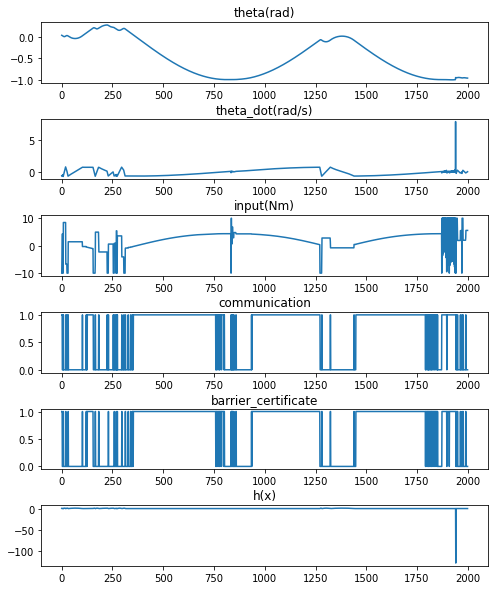

In [9]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication', 'barrier_certificate', 'h(x)'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(6):
    data = history[:,i]
    plt.subplot(6,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [35]:
a.save_weights('../learned_models_safe/3000000_e2000_l05_pure.h5')

[WARNING] ../learned_models_safe/3000000_e2000_l05_pure_actor.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] ../learned_models_safe/3000000_e2000_l05_pure_critic.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

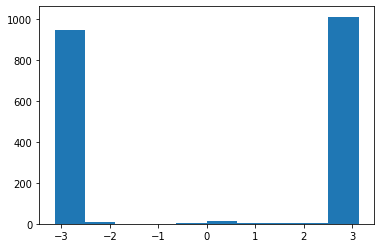

In [11]:
plt.hist(history[:,0])

In [22]:
import csv

with open("../csv/learning_log_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)

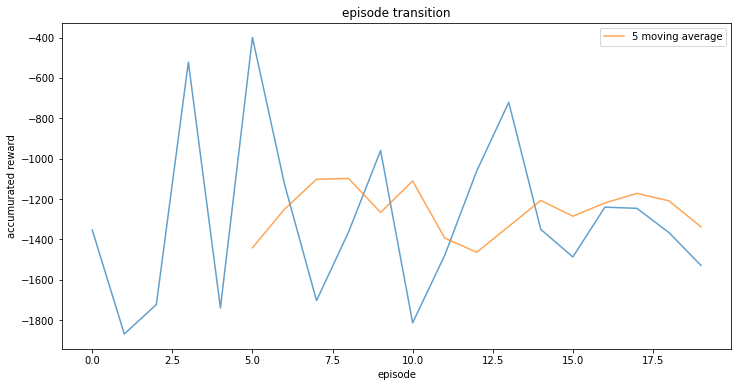

In [34]:
l = 5
plt.figure(figsize=(12,6))
ma = moving_average(a.episode_rewards, l)
plt.plot(range(len(a.episode_rewards)), a.episode_rewards, alpha=0.7)
plt.plot(range(l, len(a.episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [44]:
rewards = np.array(a.episode_rewards)
import csv

with open("../csv/episode_rewards_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in rewards:
        writer.writerow([row])

In [10]:
def single_lin_tanh(tensor):
    """ReLU with first element is linear.
    """
    dtype = tensor.dtype
    shape = (tensor.shape[1],)
    first_array = np.zeros(shape)
    first_array[0] = 1 # [1,0,0,....]
    second_array = np.ones(shape)
    second_array[0] = 0 # [0,1,1,...]

    first_tensor = K.constant(first_array)
    first_tensor = K.cast(first_tensor, dtype)
    second_tensor = K.constant(second_array)
    second_tensor = K.cast(second_tensor, dtype)

    relu = K.tanh(tensor)
    out = K.add(K.multiply(tensor, first_tensor), K.multiply(relu, second_tensor))

    return out

ZeroDivisionError: division by zero